## Step 2 - Depression
- Load in the datasets pulled from the AACT using SQL scripting in R 
- EDA 
- Export clean dataset of generic features



In [ ]:
# Import necessary packages:

import pandas as pd
import numpy as np
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

import scipy.stats as spstats
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load V2_depressionion dataset AND depression_event_table dataset
pd.set_option('display.max_columns', None)
depression_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Depression Notebooks/V2_depression.csv")
depression_df.head()
event_intervention_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Depression Notebooks/depression_event_table.csv")
event_intervention_df.head()
treatment_type_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Depression Notebooks/depression_treatment_type.csv")
treatment_type_df.head()

,Unnamed: 0,nct_id,intervention_type
0,1,NCT03866252,Drug
1,2,NCT05274620,Behavioral
2,3,NCT05274620,Other
3,4,NCT01483391,Behavioral
4,5,NCT01483391,Behavioral


### Prep Treatment Type table

In [ ]:
# Drop first column of dataframe
treatment_type_df = treatment_type_df.iloc[: , 1:]

# view df 
treatment_type_df.head()

,nct_id,intervention_type
0,NCT03866252,Drug
1,NCT05274620,Behavioral
2,NCT05274620,Other
3,NCT01483391,Behavioral
4,NCT01483391,Behavioral


In [ ]:
# keep only one row if there are identical rows in the dataframe
treatment_type_df = treatment_type_df.drop_duplicates(keep='first')

In [ ]:
# one hot encode intervention_type 
depression_dummy = (pd.concat( (pd.get_dummies(treatment_type_df['intervention_type']), treatment_type_df), axis=1, sort=False)
   .groupby('nct_id', as_index=False, sort=False)
   .agg({'intervention_type': list,'Behavioral':'sum', 'Diagnostic Test':'sum', 'Other':'sum', 'Radiation':'sum', 'Procedure':'sum', 'Device':'sum', 'Dietary Supplement':'sum', 'Genetic':'sum', 'Drug':'sum', 'Biological':'sum'})
)

# drop intervention_type column from anciety_dummy 
depression_dummy_df = depression_dummy.drop(['intervention_type'], axis=1)

In [ ]:
full_df = pd.merge(depression_df, depression_dummy_df, on = 'nct_id')

In [ ]:
full_df

,Unnamed: 0,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,number_of_sae_subjects,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological
0,1,NCT03866252,60.0,NaN,Interventional,Phase 2,2.0,False,NaN,1.0,NaN,NaN,25.0,Parallel Assignment,Randomized,Quadruple,All,No,0,0,0,0,0,0,0,0,1,0
1,2,NCT05274620,240.0,NaN,Interventional,Not Applicable,2.0,False,NaN,NaN,NaN,NaN,18.0,Sequential Assignment,Non-Randomized,None (Open Label),All,No,1,0,1,0,0,0,0,0,0,0
2,3,NCT01483391,150.0,NaN,Interventional,Not Applicable,2.0,False,True,3.0,60.0,NaN,9.0,Parallel Assignment,Randomized,Single,All,No,1,0,0,0,0,0,0,0,0,0
3,4,NCT04446039,1.0,NaN,Observational,NaN,NaN,False,False,NaN,NaN,NaN,18.0,NaN,NaN,NaN,All,NaN,0,0,0,0,0,0,0,0,1,0
4,5,NCT03315208,56.0,19.0,Interventional,Not Applicable,2.0,False,True,1.0,22.0,9.0,18.0,Parallel Assignment,Randomized,None (Open Label),All,No,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5151,5152,NCT03363919,120.0,NaN,Interventional,Not Applicable,2.0,False,True,1.0,NaN,NaN,12.0,Parallel Assignment,Randomized,Double,All,No,0,0,0,0,0,1,0,0,0,0
5152,5153,NCT04700774,117.0,NaN,Interventional,Not Applicable,3.0,False,True,NaN,NaN,NaN,18.0,Crossover Assignment,Randomized,Single,All,Accepts Healthy Volunteers,1,0,0,0,0,0,0,0,0,0
5153,5154,NCT00029588,241.0,NaN,Observational,NaN,NaN,False,NaN,2.0,NaN,NaN,9.0,NaN,NaN,NaN,All,No,0,0,0,0,0,0,0,0,0,0
5154,5155,NCT00830635,1800.0,NaN,Interventional,Not Applicable,NaN,False,False,3.0,55.0,NaN,NaN,Single Group Assignment,NaN,None (Open Label),All,No,0,0,1,0,1,0,0,0,0,0


### Create Column with percent Attrition (percent_attrtition)

In [ ]:
#create new column with percent attrition (number_dropped) dividied by (enrollment_total)
full_df["percent_attrition"] = full_df["drop_count_total"]/full_df["enrollment_total"] * 100
full_df.head()

,Unnamed: 0,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,number_of_sae_subjects,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition
0,1,NCT03866252,60.0,NaN,Interventional,Phase 2,2.0,False,NaN,1.0,NaN,NaN,25.0,Parallel Assignment,Randomized,Quadruple,All,No,0,0,0,0,0,0,0,0,1,0,NaN
1,2,NCT05274620,240.0,NaN,Interventional,Not Applicable,2.0,False,NaN,NaN,NaN,NaN,18.0,Sequential Assignment,Non-Randomized,None (Open Label),All,No,1,0,1,0,0,0,0,0,0,0,NaN
2,3,NCT01483391,150.0,NaN,Interventional,Not Applicable,2.0,False,True,3.0,60.0,NaN,9.0,Parallel Assignment,Randomized,Single,All,No,1,0,0,0,0,0,0,0,0,0,NaN
3,4,NCT04446039,1.0,NaN,Observational,NaN,NaN,False,False,NaN,NaN,NaN,18.0,NaN,NaN,NaN,All,NaN,0,0,0,0,0,0,0,0,1,0,NaN
4,5,NCT03315208,56.0,19.0,Interventional,Not Applicable,2.0,False,True,1.0,22.0,9.0,18.0,Parallel Assignment,Randomized,None (Open Label),All,No,1,0,1,0,0,0,0,0,0,0,33.928571


In [ ]:
full_df.isna().sum()

Unnamed: 0                      0
nct_id                          0
enrollment_total               59
drop_count_total             4664
study_type                      0
study_phase                   714
number_of_arms               1019
has_expanded_access            50
has_dmc                       743
number_of_facilities          444
study_duration_months        1964
number_of_sae_subjects       4794
minimum_age_num               143
intervention_model_type       759
allocation_type              1405
masking_type                  740
study_gender_eligibility        8
health_status_eligibility      68
Behavioral                      0
Diagnostic Test                 0
Other                           0
Radiation                       0
Procedure                       0
Device                          0
Dietary Supplement              0
Genetic                         0
Drug                            0
Biological                      0
percent_attrition            4664
dtype: int64

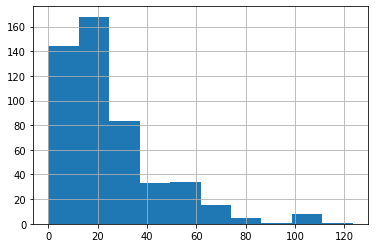

In [ ]:
# Drop first column of dataframe
full_df = full_df.iloc[: , 1:]
#distribution target variable 
#fill infinite values for nan 
full_df['percent_attrition'] = full_df['percent_attrition'].replace(np.inf, np.nan)
full_df.percent_attrition.hist()

#drop 'number_of_sae_subjects' because it has too many missing values to impute with confidence
depression_df_curated = full_df.drop(columns='number_of_sae_subjects')

In [ ]:
depression_df_curated.isna().sum()

nct_id                          0
enrollment_total               59
drop_count_total             4664
study_type                      0
study_phase                   714
number_of_arms               1019
has_expanded_access            50
has_dmc                       743
number_of_facilities          444
study_duration_months        1964
minimum_age_num               143
intervention_model_type       759
allocation_type              1405
masking_type                  740
study_gender_eligibility        8
health_status_eligibility      68
Behavioral                      0
Diagnostic Test                 0
Other                           0
Radiation                       0
Procedure                       0
Device                          0
Dietary Supplement              0
Genetic                         0
Drug                            0
Biological                      0
percent_attrition            4664
dtype: int64

### EDA

In [ ]:
#how many studies are included in this depression study investigation
len(full_df.index)
#how many studies have the enrollment total, drop count total, and target variable (percent attrtition)
full_df['enrollment_total'].count(), full_df['drop_count_total'].count(), full_df['percent_attrition'].count()

(5097, 492, 492)

In [ ]:
Counter(full_df['study_phase']) , Counter(full_df['study_gender_eligibility']) , Counter(full_df['health_status_eligibility'])

(Counter({'Phase 2': 430,
          'Not Applicable': 2656,
          nan: 714,
          'Phase 4': 481,
          'Phase 1': 225,
          'Phase 2/Phase 3': 93,
          'Phase 3': 416,
          'Phase 1/Phase 2': 85,
          'Early Phase 1': 56}),
 Counter({'All': 4664, 'Female': 414, 'Male': 70, nan: 8}),
 Counter({'No': 3809, nan: 68, 'Accepts Healthy Volunteers': 1279}))

In [ ]:
#get overview description of all columns in df
full_df.describe()

,enrollment_total,drop_count_total,number_of_arms,number_of_facilities,study_duration_months,number_of_sae_subjects,minimum_age_num,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition
count,5.097000e+03,492.000000,4137.000000,4712.000000,3192.000000,362.000000,5013.000000,5156.00000,5156.000000,5156.000000,5156.000000,5156.000000,5156.000000,5156.000000,5156.000000,5156.000000,5156.000000,492.000000
mean,4.083439e+03,72.518293,2.170413,4.623727,30.918860,15.908840,21.275284,0.37723,0.007176,0.177851,0.001939,0.034717,0.110357,0.017261,0.003103,0.318658,0.005818,24.699736
std,1.751953e+05,146.031096,1.120503,14.137361,26.501231,44.591404,11.803104,0.48474,0.084416,0.382424,0.044001,0.183079,0.313364,0.130257,0.055625,0.466001,0.076064,20.432943
min,0.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075245
25%,3.600000e+01,5.000000,2.000000,1.000000,13.000000,2.000000,18.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.702082
50%,8.900000e+01,17.500000,2.000000,1.000000,25.000000,5.000000,18.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.763646
75%,2.320000e+02,72.250000,2.000000,1.000000,43.000000,13.000000,18.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,32.131925
max,1.200000e+07,1270.000000,24.000000,256.000000,571.000000,645.000000,75.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,123.404255


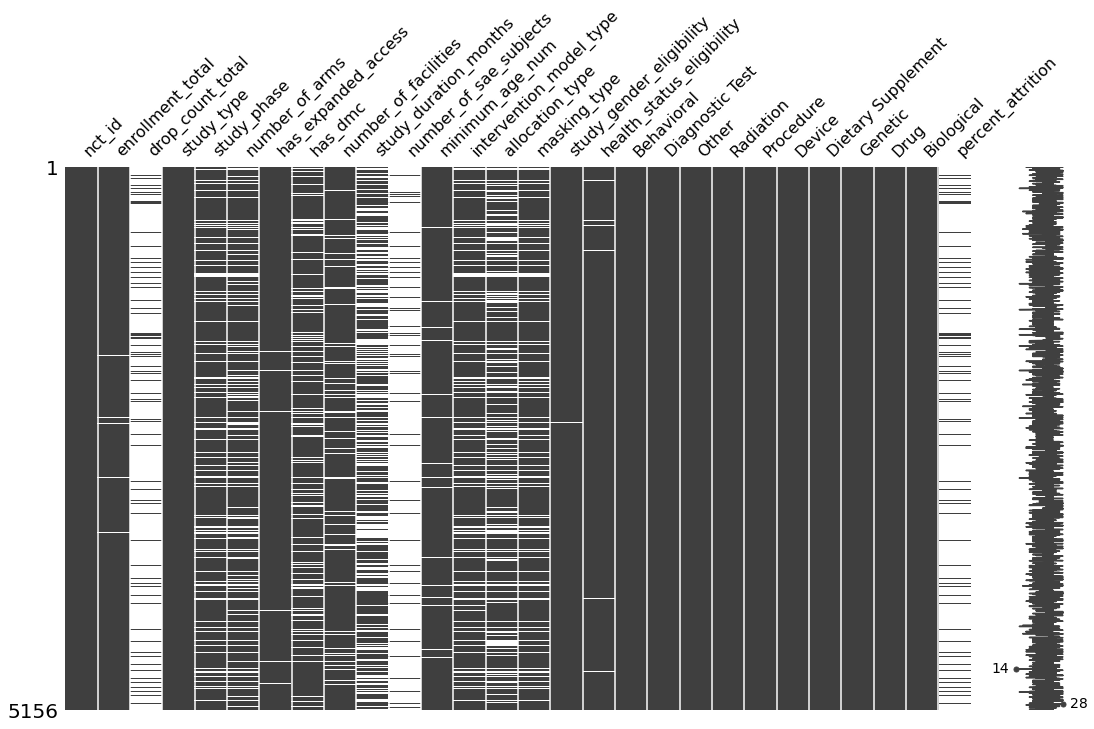

In [ ]:
#visualize missing values
import missingno as msno

missingdata_df = full_df.columns[full_df.isnull().any()].tolist()
msno.matrix(full_df,figsize=(18,10))

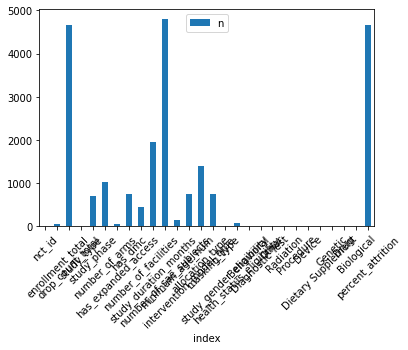

In [ ]:
full_df.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=45)

In [ ]:
full_df.isna().sum()

nct_id                          0
enrollment_total               59
drop_count_total             4664
study_type                      0
study_phase                   714
number_of_arms               1019
has_expanded_access            50
has_dmc                       743
number_of_facilities          444
study_duration_months        1964
number_of_sae_subjects       4794
minimum_age_num               143
intervention_model_type       759
allocation_type              1405
masking_type                  740
study_gender_eligibility        8
health_status_eligibility      68
Behavioral                      0
Diagnostic Test                 0
Other                           0
Radiation                       0
Procedure                       0
Device                          0
Dietary Supplement              0
Genetic                         0
Drug                            0
Biological                      0
percent_attrition            4664
dtype: int64

### Create Event columns with event count in respective columns AND convert 

In [ ]:
event_intervention_df.head()
# Drop first column of dataframe
event_intervention_df = event_intervention_df.iloc[: , 1:]

In [ ]:
event_intervention_df

,nct_id,subjects_affected_total,event_type
0,NCT00000367,NaN,NaN
1,NCT00000375,NaN,NaN
2,NCT00000376,NaN,NaN
3,NCT00000377,NaN,NaN
4,NCT00000378,6.0,other
...,...,...,...
7080,NCT05417412,NaN,NaN
7081,NCT05418894,NaN,NaN
7082,NCT05419869,NaN,NaN
7083,NCT05422417,NaN,NaN


In [ ]:
# One-hot-encode categorical:
prefix_cols = ['event_type']
dummy_cols = ['event_type']
              
event_df = pd.get_dummies(event_intervention_df, prefix=prefix_cols, columns=dummy_cols)

In [ ]:
event_df.head()

,nct_id,subjects_affected_total,event_type_deaths,event_type_other,event_type_serious
0,NCT00000367,NaN,0,0,0
1,NCT00000375,NaN,0,0,0
2,NCT00000376,NaN,0,0,0
3,NCT00000377,NaN,0,0,0
4,NCT00000378,6.0,0,1,0


In [ ]:
# fill all flag values == 1 with nan
event_df[['event_type_deaths', 'event_type_other', 'event_type_serious']] = event_df[['event_type_deaths', 'event_type_other', 'event_type_serious']].replace(1, np.NaN)

# replace nan values in the three event type columns with the corresponding count value from subjects_affected_total column
event_df.event_type_other.fillna(event_df.subjects_affected_total, inplace=True)
event_df.event_type_deaths.fillna(event_df.subjects_affected_total, inplace=True)
event_df.event_type_serious.fillna(event_df.subjects_affected_total, inplace=True)

#group responses from the merged column (type of event and count) by nct_id
event_total_df = event_df.groupby('nct_id').sum()

#drop column subjects_affected_total 
event_final_df = event_total_df.drop(['subjects_affected_total'], axis=1)

In [ ]:
event_final_df

,event_type_deaths,event_type_other,event_type_serious
nct_id,,,
NCT00000367,0.0,0.0,0.0
NCT00000375,0.0,0.0,0.0
NCT00000376,0.0,0.0,0.0
NCT00000377,0.0,0.0,0.0
NCT00000378,0.0,6.0,0.0
...,...,...,...
NCT05417087,0.0,0.0,0.0
NCT05417412,0.0,0.0,0.0
NCT05418894,0.0,0.0,0.0


In [ ]:
full_df = pd.merge(depression_df_curated, event_final_df, on = 'nct_id')

In [ ]:
full_df

,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition,event_type_deaths,event_type_other,event_type_serious
0,NCT03866252,60.0,NaN,Interventional,Phase 2,2.0,False,NaN,1.0,NaN,25.0,Parallel Assignment,Randomized,Quadruple,All,No,0,0,0,0,0,0,0,0,1,0,NaN,0.0,0.0,0.0
1,NCT05274620,240.0,NaN,Interventional,Not Applicable,2.0,False,NaN,NaN,NaN,18.0,Sequential Assignment,Non-Randomized,None (Open Label),All,No,1,0,1,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0
2,NCT01483391,150.0,NaN,Interventional,Not Applicable,2.0,False,True,3.0,60.0,9.0,Parallel Assignment,Randomized,Single,All,No,1,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0
3,NCT04446039,1.0,NaN,Observational,NaN,NaN,False,False,NaN,NaN,18.0,NaN,NaN,NaN,All,NaN,0,0,0,0,0,0,0,0,1,0,NaN,0.0,0.0,0.0
4,NCT03315208,56.0,19.0,Interventional,Not Applicable,2.0,False,True,1.0,22.0,18.0,Parallel Assignment,Randomized,None (Open Label),All,No,1,0,1,0,0,0,0,0,0,0,33.928571,0.0,21.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5151,NCT03363919,120.0,NaN,Interventional,Not Applicable,2.0,False,True,1.0,NaN,12.0,Parallel Assignment,Randomized,Double,All,No,0,0,0,0,0,1,0,0,0,0,NaN,0.0,0.0,0.0
5152,NCT04700774,117.0,NaN,Interventional,Not Applicable,3.0,False,True,NaN,NaN,18.0,Crossover Assignment,Randomized,Single,All,Accepts Healthy Volunteers,1,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0
5153,NCT00029588,241.0,NaN,Observational,NaN,NaN,False,NaN,2.0,NaN,9.0,NaN,NaN,NaN,All,No,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0
5154,NCT00830635,1800.0,NaN,Interventional,Not Applicable,NaN,False,False,3.0,55.0,NaN,Single Group Assignment,NaN,None (Open Label),All,No,0,0,1,0,1,0,0,0,0,0,NaN,0.0,0.0,0.0


### Handle Missing Values

In [ ]:
#impute all non integer missing values with "Not Reported"

#drop all rows that do not have an outcome values (555 studies remain)
full_df.dropna(subset=['percent_attrition'])
#drop all rows that have percent_attrition greater than 100%
df_filtered = full_df[full_df['percent_attrition'] < 100]
#impute all study_phase missing values with "unknown"
df_filtered[['study_phase', 'intervention_model_type', 'allocation_type', 'masking_type']] = df_filtered[['study_phase', 'intervention_model_type', 'allocation_type', 'masking_type']].fillna('Not Reported')
#fill nan values in had_dmc column with false 
df_filtered['has_dmc'] = df_filtered['has_dmc'].fillna(False)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df_filtered.isna().sum()

nct_id                        0
enrollment_total              0
drop_count_total              0
study_type                    0
study_phase                   0
number_of_arms               11
has_expanded_access           0
has_dmc                       0
number_of_facilities         26
study_duration_months         0
minimum_age_num               6
intervention_model_type       0
allocation_type               0
masking_type                  0
study_gender_eligibility      0
health_status_eligibility     0
Behavioral                    0
Diagnostic Test               0
Other                         0
Radiation                     0
Procedure                     0
Device                        0
Dietary Supplement            0
Genetic                       0
Drug                          0
Biological                    0
percent_attrition             0
event_type_deaths             0
event_type_other              0
event_type_serious            0
dtype: int64

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name_

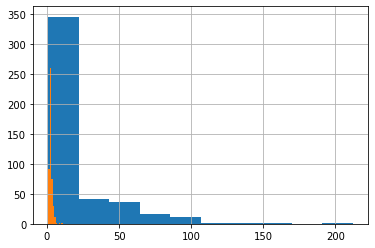

In [ ]:
#visulalize data to determine imputation with mean or median
df_filtered.number_of_facilities.hist(), df_filtered.number_of_arms.hist()

#impute all integer missing values with median (because of large skew to these two features)
df_filtered.fillna(df_filtered['number_of_facilities'].median(), inplace = True)
df_filtered.fillna(df_filtered['number_of_arms'].median(), inplace = True)

#impute all missing values from minimum_age_num with 1000 as place holder for 'Not Reported'
df_filtered['minimum_age_num'] = df_filtered['minimum_age_num'].fillna(1000)

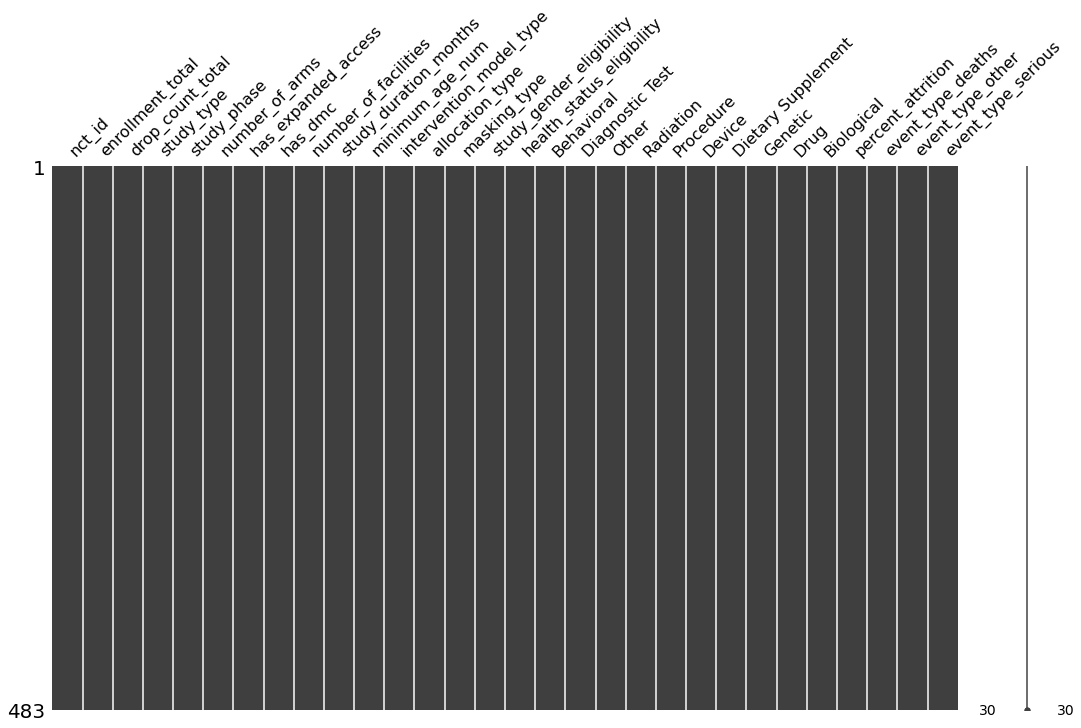

In [ ]:
#count missing values
df_filtered.isna().sum()
 
#visualize missing values
missingdata_df = df_filtered.columns[df_filtered.isnull().any()].tolist()
msno.matrix(df_filtered,figsize=(18,10))

### Categorize minimum_age column to pediatric / non-pediatric

In [ ]:
#categorize minimum_age_num into three categories "pediatric", "Not Pediatric", or "Not Reported"
df_filtered['minimum_age_num'] = pd.cut(x=df_filtered['minimum_age_num'], bins=[0, 17, 150, 1000],
                     labels=['Pediatric Subjects Included', 'No Pediatric Subjects Included', 'Not Reported'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_filtered.shape

(483, 30)

In [ ]:
df_filtered.head()

,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition,event_type_deaths,event_type_other,event_type_serious
4,NCT03315208,56.0,19.0,Interventional,Not Applicable,2.0,False,True,1.0,22.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,None (Open Label),All,No,1,0,1,0,0,0,0,0,0,0,33.928571,0.0,21.0,9.0
19,NCT00574145,44.0,3.0,Interventional,Not Applicable,2.0,False,True,3.0,26.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,None (Open Label),Female,No,0,0,0,0,1,0,0,0,0,0,6.818182,0.0,0.0,0.0
24,NCT01973283,100.0,4.0,Interventional,Phase 4,1.0,False,False,1.0,70.0,No Pediatric Subjects Included,Single Group Assignment,Not Reported,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,4.000000,0.0,0.0,2.0
36,NCT00511810,20.0,6.0,Interventional,Phase 2/Phase 3,2.0,False,True,1.0,43.0,Pediatric Subjects Included,Parallel Assignment,Randomized,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,30.000000,0.0,0.0,2.0
38,NCT01421342,1522.0,973.0,Interventional,Phase 3,3.0,False,True,35.0,32.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,63.929041,8.0,1126.0,165.0


### Classify outcome variable into low, medium, high atttrition levels 

In [ ]:
MIN = 100
MAX = 0
df_filtered['percent_attrition'].sub(MIN).div(MAX-MIN).clip(0, 1)

4       0.660714
19      0.931818
24      0.960000
36      0.700000
38      0.360710
          ...   
5064    0.842650
5094    0.791667
5102    0.654299
5112    0.696970
5117    0.346734
Name: percent_attrition, Length: 483, dtype: float64

Text(0, 0.5, 'Frequency')

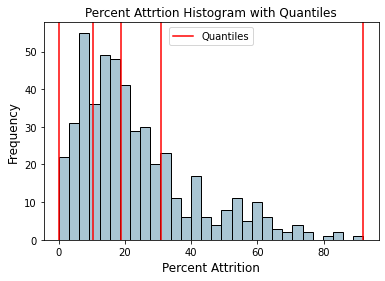

In [ ]:
quantile_list = [0, .25, .50, .75, 1.]
quantiles = df_filtered['percent_attrition'].quantile(quantile_list)
quantiles

fig, ax = plt.subplots()
df_filtered['percent_attrition'].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Percent Attrtion Histogram with Quantiles', 
             fontsize=12)
ax.set_xlabel('Percent Attrition', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [ ]:
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
df_filtered['quantile_attrition_range'] = pd.qcut(
                                            df_filtered['percent_attrition'], 
                                            q=quantile_list)
df_filtered['quantile_attrition_range'] = pd.qcut(
                                            df_filtered['percent_attrition'], 
                                            q=quantile_list,       
                                            labels=quantile_labels)
df_filtered

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nct_id,enrollment_total,drop_count_total,study_type,study_phase,number_of_arms,has_expanded_access,has_dmc,number_of_facilities,study_duration_months,minimum_age_num,intervention_model_type,allocation_type,masking_type,study_gender_eligibility,health_status_eligibility,Behavioral,Diagnostic Test,Other,Radiation,Procedure,Device,Dietary Supplement,Genetic,Drug,Biological,percent_attrition,event_type_deaths,event_type_other,event_type_serious,quantile_attrition_range
4,NCT03315208,56.0,19.0,Interventional,Not Applicable,2.0,False,True,1.0,22.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,None (Open Label),All,No,1,0,1,0,0,0,0,0,0,0,33.928571,0.0,21.0,9.0,75-100Q
19,NCT00574145,44.0,3.0,Interventional,Not Applicable,2.0,False,True,3.0,26.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,None (Open Label),Female,No,0,0,0,0,1,0,0,0,0,0,6.818182,0.0,0.0,0.0,0-25Q
24,NCT01973283,100.0,4.0,Interventional,Phase 4,1.0,False,False,1.0,70.0,No Pediatric Subjects Included,Single Group Assignment,Not Reported,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,4.000000,0.0,0.0,2.0,0-25Q
36,NCT00511810,20.0,6.0,Interventional,Phase 2/Phase 3,2.0,False,True,1.0,43.0,Pediatric Subjects Included,Parallel Assignment,Randomized,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,30.000000,0.0,0.0,2.0,50-75Q
38,NCT01421342,1522.0,973.0,Interventional,Phase 3,3.0,False,True,35.0,32.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,None (Open Label),All,No,0,0,0,0,0,0,0,0,1,0,63.929041,8.0,1126.0,165.0,75-100Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5064,NCT00985504,483.0,76.0,Interventional,Phase 4,2.0,False,False,15.0,15.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Triple,All,No,0,0,0,0,0,0,0,0,1,0,15.734990,0.0,230.0,6.0,25-50Q
5094,NCT00612313,144.0,30.0,Interventional,Not Applicable,2.0,False,True,1.0,60.0,Pediatric Subjects Included,Parallel Assignment,Randomized,Single,All,No,1,0,0,0,0,0,0,0,1,0,20.833333,0.0,0.0,16.0,50-75Q
5102,NCT01436162,1105.0,382.0,Interventional,Phase 3,2.0,False,False,101.0,26.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Quadruple,All,No,0,0,0,0,0,0,0,0,1,0,34.570136,0.0,118.0,2.0,75-100Q
5112,NCT02085135,66.0,20.0,Interventional,Phase 3,2.0,False,False,9.0,7.0,No Pediatric Subjects Included,Parallel Assignment,Randomized,Quadruple,All,No,0,0,0,0,0,0,0,0,1,0,30.303030,0.0,51.0,0.0,50-75Q


In [ ]:
# specifying bins and allowing the qcut function to divide the data
#pd.qcut(df_filtered['percent_attrition'], q=3)

#check values counts in each bin 
#pd.qcut(df_filtered['percent_attrition'], q=3).value_counts()

#cut_category = ['Low Attrition', 'Medium Attrition', 'High Attrition']
#cut_bins =[0, 13.160, 25.86, 92.1]
#df_filtered['quantile_attrition_range'] = pd.cut(df_filtered['percent_attrition'], bins=cut_bins, labels = cut_category)

### Export clean Depression File

In [ ]:
df_filtered['percent_attrition'].describe()
#download cleaned data
df_filtered.to_csv('/content/drive/MyDrive/HIDS510/Collab Notebooks/Depression Notebooks/depression_clean_df.csv')